In [1]:
import sys
import os
sys.path.append("/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/PSPNet-Keras-tensorflow") # access submodules
# filter out paths added by other users of server...
sys.path = [p for p in sys.path if not p.startswith('/local/scratch') or p.startswith('/local/scratch/js2173')]

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # set to 0 to use GPU if its available

In [3]:
from os.path import splitext, join
import numpy as np
import argparse
from scipy import misc, ndimage
from keras import backend as K
from keras.models import model_from_json, load_model
import tensorflow as tf
import layers_builder as layers
from python_utils import utils
from python_utils.preprocessing import preprocess_img

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from pspnet import PSPNet101


/local/scratch/js2173/pytorch/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
pspnet_path =  '/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/PSPNet-Keras-tensorflow'
#filename = "epoch100_real_image.jpg"
filename = "epoch103_real_image.jpg"
input_path = join('example_images', filename)
input_size = 512
output_path = join('example_results', filename)
model = "pspnet101_cityscapes"

In [5]:
sess = tf.Session()
K.set_session(sess)

# testing...
# with sess.as_default():
#     img = misc.imread(input_path, mode='RGB')
#     #cimg = misc.imresize(img, (input_size, input_size))
#     pspnet = PSPNet101(nb_classes=19, input_shape=(713, 713), weights_name=model, weights_path=pspnet_path)


#     probs = pspnet.predict(img, flip_evaluation=False)

#     print("Writing results...")
#     cm = np.argmax(probs, axis=2)
#     pm = np.max(probs, axis=2)
    

#     color_cm = utils.add_color(cm)
#     # color cm is [0.0-1.0] img is [0-255]
#     alpha_blended = 0.5 * color_cm * 255 + 0.5 * img
#     filename, ext = splitext(output_path)
#     misc.imsave(filename + "_seg_read" + ext, cm)
#     misc.imsave(filename + "_seg" + ext, color_cm)
#     misc.imsave(filename + "_probs" + ext, pm)
#     misc.imsave(filename + "_seg_blended" + ext, alpha_blended)


In [6]:
cityscapes_id_to_name = {
    0 : "road",
    1 : "sidewalk",
    2 : "building",
    3 : "wall",
    4 : "fence",
    5 : "pole",
    6 : "light",
    7 : "sign",
    8 : "vegetation",
    9 : "terrain",
    10 : "sky",
    11 : "person",
    12 : "rider",
    13 : "car",
    14 : "truck",
    15 : "bus",
    16 : "train",
    17 : "motocycle",
    18 : "bicycle"
}
cityscapes_name_to_id = dict([(val, key) for (key, val) in cityscapes_id_to_name.items()])


def extract_region_mask(image, region_id, pspnet, sess=None):
    if sess is None:
        sess = tf.Session()
        K.set_session(sess)
    
    with sess.as_default():
        probs = pspnet.predict(image, flip_evaluation=False)
        classes = np.argmax(probs, axis=2)
        return classes == region_id


In [7]:
def show_img(im, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    imgplot = plt.imshow(im)

In [8]:
img = misc.imread(input_path, mode='RGB')


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [9]:
import keras_neural_style_transfer as style_transfer
from keras.preprocessing.image import load_img, img_to_array
st = style_transfer.NeuralStyleTransfer()

In [10]:
style_image = misc.imread('styles/yellow_bricks.png')[:, :, :3]
target_width = 750
iters = 10
target_height = int(img.shape[0] * target_width / img.shape[1])
target_shape = (target_height, target_width)
print(target_shape)

(375, 750)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [11]:
#print(transferred.shape)
pspnet = PSPNet101(nb_classes=19, input_shape=(713, 713), weights_name=model, weights_path=pspnet_path)

resized_img = misc.imresize(img, target_shape)
mask = extract_region_mask(resized_img, 0, pspnet, sess=sess)
print(mask.shape)

/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/PSPNet-Keras-tensorflow/weights/keras/pspnet101_cityscapes.h5
Keras model & weights found, loading...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Predicting...


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Finished prediction...
(375, 750)


In [12]:
# black out non-semantic regions
black_out = resized_img.copy()
# fill with mean black
#black_out[~mask] = 0
# fill mean mean color
#mean_color = np.mean(black_out[~mask], axis=(0,1))
#black_out[~mask] = mean_color
black_out_transferred = st.transfer(black_out, style_image, target_width=target_width, iters_override=iters)

375 750
Model loaded.
Start of iteration 0
Current loss value: 1059040800000.0
Image saved as restyled_at_iteration_0.png
Iteration 0 completed in 7s
Start of iteration 1
Current loss value: 737984250000.0
Image saved as restyled_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 596529400000.0
Image saved as restyled_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 507665250000.0
Image saved as restyled_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 444172570000.0
Image saved as restyled_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 397647870000.0
Image saved as restyled_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 359085240000.0
Image saved as restyled_at_iteration_6.png
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 326137740000.0
Image saved as restyled_at_itera

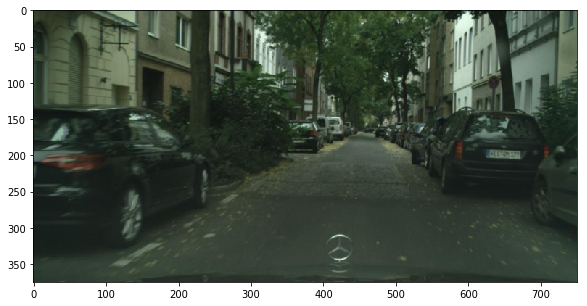

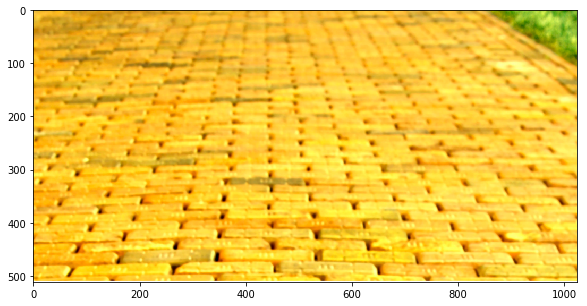

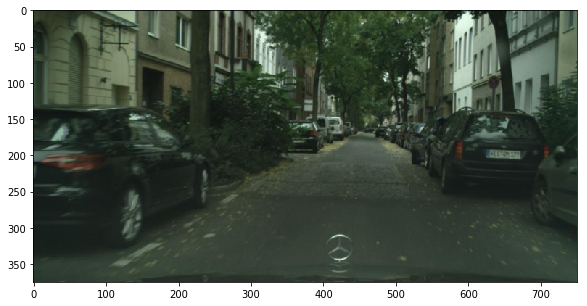

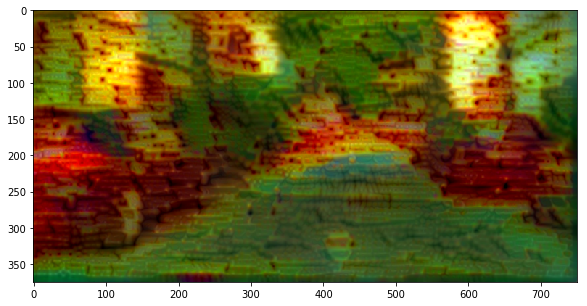

In [13]:
show_img(resized_img, figsize=(10,5))
show_img(style_image, figsize=(10,5))
show_img(black_out, figsize=(10,5))
show_img(black_out_transferred, figsize=(10,5))

(375, 750) (375, 750, 3) (375, 750, 3)


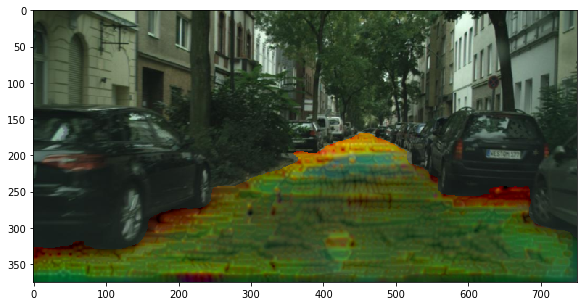

In [14]:
print(mask.shape, black_out_transferred.shape, resized_img.shape)
restyled_copy = black_out_transferred.copy()
#resized_img_copy[~mask] = 0
orig_resized = resized_img.copy()
orig_resized[mask] = restyled_copy[mask]
show_img(orig_resized, figsize=(10,5))

In [15]:


# show_img(style_image)
# show_img(img)
transferred = st.transfer(img, style_image, target_width=target_width, iters_override=iters)


375 750
Model loaded.
Start of iteration 0
Current loss value: 1059040800000.0
Image saved as restyled_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 737984250000.0
Image saved as restyled_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 596529400000.0
Image saved as restyled_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 507665250000.0
Image saved as restyled_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 444172570000.0
Image saved as restyled_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 397647870000.0
Image saved as restyled_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 359085240000.0
Image saved as restyled_at_iteration_6.png
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 326137740000.0
Image saved as restyled_at_itera

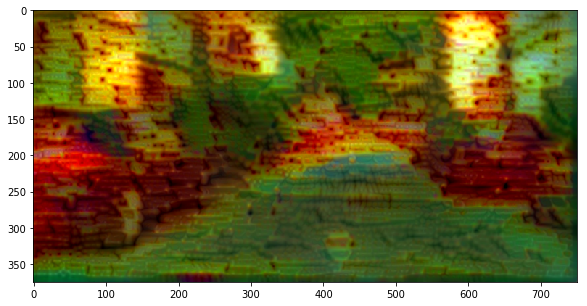

In [16]:
show_img(transferred, figsize=(10,5))

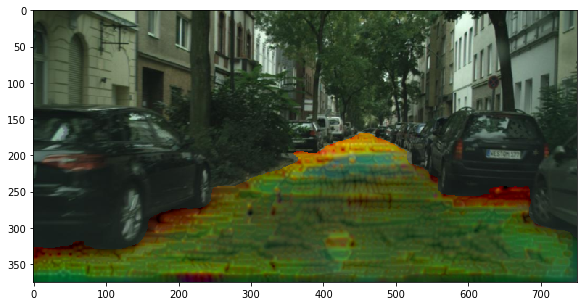

In [17]:
restyled_copy = transferred.copy()
#resized_img_copy[~mask] = 0
orig_resized = resized_img.copy()
orig_resized[mask] = restyled_copy[mask]

show_img(orig_resized, figsize=(10,5))

In [18]:
# experiment with masking out the original image black in areas we don't want it
# then use that as the style image!
original_copy = resized_img.copy()
resized_image_copy = resized_img.copy()
resized_image_copy[~mask] = 0
inverse_transferred = st.transfer(style_image, style=resized_image_copy, target_width=target_width, iters_override=iters)

375 750
Model loaded.
Start of iteration 0
Current loss value: 413441430000.0
Image saved as restyled_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 324248300000.0
Image saved as restyled_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 290825100000.0
Image saved as restyled_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 274175560000.0
Image saved as restyled_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 264147710000.0
Image saved as restyled_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 257170260000.0
Image saved as restyled_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 251988870000.0
Image saved as restyled_at_iteration_6.png
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 248104010000.0
Image saved as restyled_at_iterat

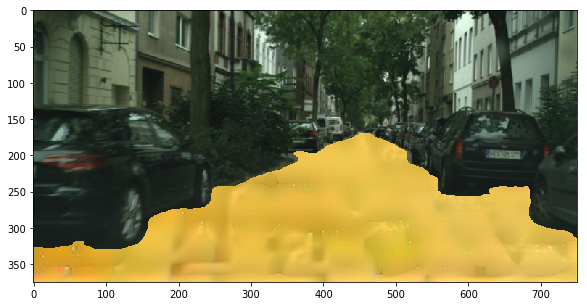

In [19]:
original_copy[mask] = inverse_transferred[mask]
show_img(original_copy, figsize=(10,5))